In [6]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate


# visualize_data.ipynb

In [1]:
from train import *

==> CONFIG is: 
 {'INIT': None, 'LOGS': {'SNAPSHOT_FREQ': 1000, 'SNAPSHOT_DIR': 'snapshot', 'PRINT_FREQ': 10, 'SNAPSHOT_MAXFILES': 'NOTIMPLEMENT', 'LOG_DIR': 'logs', 'LOG_SHUTIL_IGNORELIST': ['.git', 'snapshot', 'logs'], 'LOG_SHUTIL_IGNOREFILE': '.gitignore', 'LOG_FREQ': 100, 'LOG_SHUTIL_ON': True}, 'NAME': 'Mask_RCNN', 'MODEL': {'CLS_AGNOSTIC_BBOX_REG': False, 'BBOX_REG_WEIGHTS': [10.0, 10.0, 5.0, 5.0]}, 'TRAIN': {'BG_THRESH_HI': 0.5, 'RPN_BATCH_SIZE_PER_IM': 256, 'SCALES': [600], 'FG_THRESH': 0.5, 'BBOX_THRESH': 0.5, 'RPN_NEGATIVE_OVERLAP': 0.3, 'RPN_FG_FRACTION': 0.5, 'RPN_STRADDLE_THRESH': 0, 'MAX_SIZE': 1000, 'RPN_POSITIVE_OVERLAP': 0.7, 'BG_THRESH_LO': 0.0, 'GT_MIN_AREA': -1}, 'FPN': {'COARSEST_STRIDE': 32}, 'DEBUG': True, 'AUGS': {'FLIP_ON': True}, 'DATASET': {'INPUT_RES': 1024, 'VAL_DIR': '/home/dalong/data/coco2017/val2017', 'TRAIN_DIR': '/home/dalong/data/coco2017/train2017', 'MEAN': [102.9801, 115.9465, 122.7717], 'TRAIN_ANNOFILE': '/home/dalong/data/coco2017/annotations/ins

In [2]:
dataset = CocoDataset(CONFIG.DATASET.TRAIN_DIR, CONFIG.DATASET.TRAIN_ANNOFILE) 

loading annotations into memory...
Done (t=24.65s)
creating index...
index created!


In [3]:
Batch = dataset.collate_minibatch([dataset[i] for i in range(CONFIG.SOLVER.IMS_PER_BATCH * 2)])

# Vis Data Attribute

In [4]:
print ('Batch.keys():', Batch.keys())

Batch.keys(): dict_keys(['rpn_labels_int32_wide', 'im_info', 'rpn_bbox_outside_weights_wide', 'data', 'rpn_bbox_targets_wide', 'rpn_bbox_inside_weights_wide', 'roidb'])


In [5]:
for key in Batch:
    print (key, len(Batch[key]), type(Batch[key][0])) 

rpn_labels_int32_wide 2 <class 'torch.IntTensor'>
im_info 2 <class 'torch.FloatTensor'>
rpn_bbox_outside_weights_wide 2 <class 'torch.FloatTensor'>
data 2 <class 'torch.FloatTensor'>
rpn_bbox_targets_wide 2 <class 'torch.FloatTensor'>
rpn_bbox_inside_weights_wide 2 <class 'torch.FloatTensor'>
roidb 2 <class 'list'>


In [6]:
# See what in Batch[0] (for GPU 0).

In [7]:
gpuid = 0
print ('Batch[\'im_info\'][gpuid]:', Batch['im_info'][gpuid])
gpuid = 1
print ('Batch[\'im_info\'][gpuid]:', Batch['im_info'][gpuid])

Batch['im_info'][gpuid]: 
 600.0000  800.0000    1.2500
 600.0000  901.0000    1.4085
 600.0000  897.0000    1.4019
 600.0000  904.0000    1.4118
[torch.FloatTensor of size 4x3]

Batch['im_info'][gpuid]: 
 798.0000  600.0000    1.2474
 600.0000  803.0000    1.2552
 787.0000  600.0000    1.5748
 600.0000  787.0000    1.2295
[torch.FloatTensor of size 4x3]



In [8]:
gpuid = 0
print ('Batch[\'rpn_labels_int32_wide\'][gpuid]:', Batch['rpn_labels_int32_wide'][gpuid].shape)
print ('Batch[\'rpn_bbox_targets_wide\'][gpuid]:', Batch['rpn_bbox_targets_wide'][gpuid].shape)
print ('Batch[\'rpn_bbox_inside_weights_wide\'][gpuid]:', Batch['rpn_bbox_inside_weights_wide'][gpuid].shape)
print ('Batch[\'rpn_bbox_outside_weights_wide\'][gpuid]:', Batch['rpn_bbox_outside_weights_wide'][gpuid].shape)

print (np.max(Batch['rpn_labels_int32_wide'][gpuid][0].numpy()))

Batch['rpn_labels_int32_wide'][gpuid]: torch.Size([4, 12, 64, 64])
Batch['rpn_bbox_targets_wide'][gpuid]: torch.Size([4, 48, 64, 64])
Batch['rpn_bbox_inside_weights_wide'][gpuid]: torch.Size([4, 48, 64, 64])
Batch['rpn_bbox_outside_weights_wide'][gpuid]: torch.Size([4, 48, 64, 64])
1


In [9]:
gpuid = 0
print ('Batch[\'data\'][gpuid]:', Batch['data'][gpuid].shape)
gpuid = 1
print ('Batch[\'data\'][gpuid]:', Batch['data'][gpuid].shape)

Batch['data'][gpuid]: torch.Size([4, 3, 600, 904])
Batch['data'][gpuid]: torch.Size([4, 3, 798, 803])


In [10]:
# See what's in Batch['roidb'][gpuid]

In [11]:
gpuid = 0
'''
Batch['roidb'][gpuid] = [
    [ dict {'gt_overlaps': <class 'scipy.sparse.csr.csr_matrix'>, (GtN, 81)
            'box_to_gt_ind_map': <class 'numpy.ndarray'>, (GtN,)
            'boxes':  <class 'numpy.ndarray'>, (GtN, 4)
            'seg_areas': <class 'numpy.ndarray'>, (GtN,)
            'is_crowd': <class 'numpy.ndarray'>, (GtN,)
            'segms': <class 'list'>, [GtN]
            'gt_classes': <class 'numpy.ndarray'> (GtN,)
            } ],
    [],
    [],
    []
]
'''

for i in Batch['roidb'][gpuid]:
    print (type(i), len(i), type(i[0]), i[0].keys())
    for key in i[0].keys():
        print (key, type(i[0][key]), )
        if not isinstance(i[0][key], list):
            print (i[0][key].shape)
        else:
            print (len(i[0][key]))
    print ('=======')


<class 'list'> 1 <class 'dict'> dict_keys(['gt_overlaps', 'gt_classes', 'segms', 'box_to_gt_ind_map', 'seg_areas', 'boxes', 'is_crowd'])
gt_overlaps <class 'scipy.sparse.csr.csr_matrix'>
(8, 81)
gt_classes <class 'numpy.ndarray'>
(8,)
segms <class 'list'>
8
box_to_gt_ind_map <class 'numpy.ndarray'>
(8,)
seg_areas <class 'numpy.ndarray'>
(8,)
boxes <class 'numpy.ndarray'>
(8, 4)
is_crowd <class 'numpy.ndarray'>
(8,)
<class 'list'> 1 <class 'dict'> dict_keys(['gt_overlaps', 'gt_classes', 'segms', 'box_to_gt_ind_map', 'seg_areas', 'boxes', 'is_crowd'])
gt_overlaps <class 'scipy.sparse.csr.csr_matrix'>
(2, 81)
gt_classes <class 'numpy.ndarray'>
(2,)
segms <class 'list'>
2
box_to_gt_ind_map <class 'numpy.ndarray'>
(2,)
seg_areas <class 'numpy.ndarray'>
(2,)
boxes <class 'numpy.ndarray'>
(2, 4)
is_crowd <class 'numpy.ndarray'>
(2,)
<class 'list'> 1 <class 'dict'> dict_keys(['gt_overlaps', 'gt_classes', 'segms', 'box_to_gt_ind_map', 'seg_areas', 'boxes', 'is_crowd'])
gt_overlaps <class 'scipy

# Vis Data In Image

im_info_single: (3,) 800.0 1.25
data_single: (3, 600, 904) 152.0199 -122.7717
roidb_single: dict_keys(['gt_overlaps', 'gt_classes', 'segms', 'box_to_gt_ind_map', 'seg_areas', 'boxes', 'is_crowd'])
rpn_labels_int32_wide_single: (12, 64, 64) 1 -1
rpn_bbox_targets_wide_single: (48, 64, 64) 0.46641648 -0.3759728
rpn_bbox_inside_weights_wide_single: (48, 64, 64) 1.0 0.0
rpn_bbox_outside_weights_wide_single: (48, 64, 64) 0.003921569 0.0
[480 * 640] -[scale 1.250000]-> [600 * 800] -(padding)-> [600 * 904]


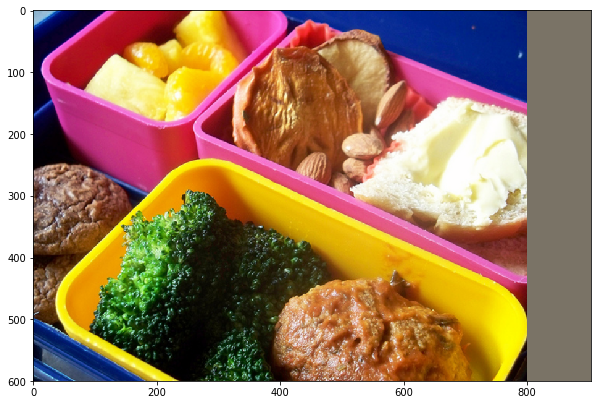

(49152, 4)


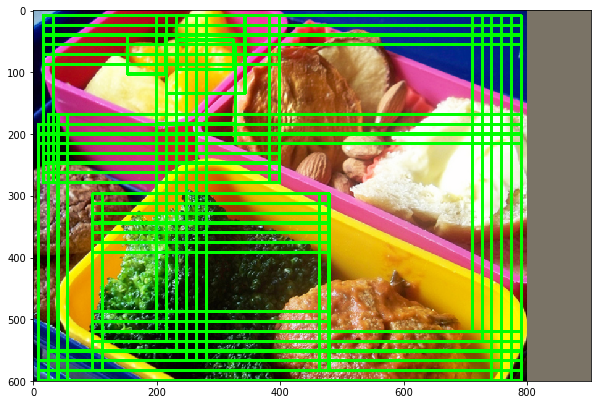

total has 8 instances in this image.
gt_overlaps:   (0, 46)	1.0
box_to_gt_ind_map: 0
boxes: [ 27.330017 187.69     637.92     472.53    ]
seg_areas: 120057.14
is_crowd: False
segms: [[138.51, 473.53, 39.26999999999998, 419.6, 26.33000000000004, 375.37, 30.639999999999986, 354.88, 110.46000000000004, 269.66, 181.64999999999998, 201.71, 218.32999999999998, 187.69, 249.61, 192.0, 619.58, 360.27, 637.92, 389.39, 636.84, 427.15, 618.51, 473.53]]
gt_classes: 46
bowl


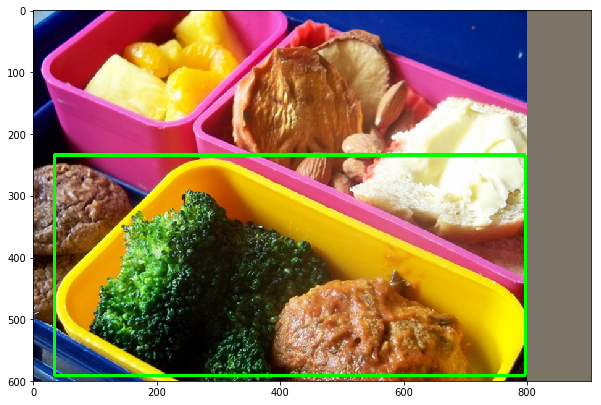

mask.shape (480, 640)


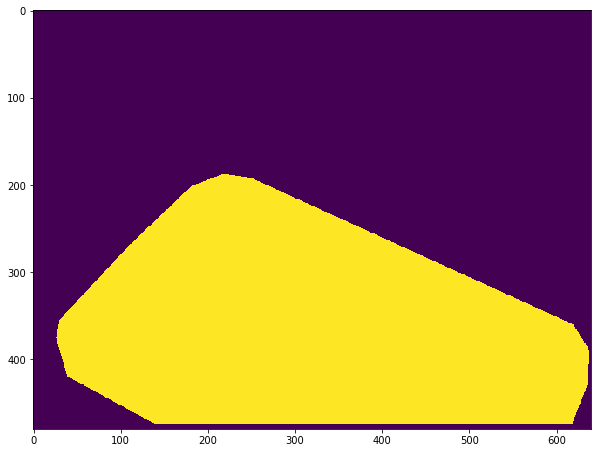

In [23]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

import copy

def vis_Batch(_Batch):
    '''
    Batch['im_info'][gpuid] = <class 'torch.FloatTensor'>, torch.Size([minibz, (img_height, img_width, img_scale)]) 
    Batch['data'][gpuid] = <class 'torch.FloatTensor'>, torch.Size([minibz, 3, minibatch_height, minibatch_width])
    Batch['roidb'][gpuid] = [
        [ dict {'gt_overlaps': <class 'scipy.sparse.csr.csr_matrix'>, (GtN, 81)
                'box_to_gt_ind_map': <class 'numpy.ndarray'>, (GtN,)
                'boxes':  <class 'numpy.ndarray'>, (GtN, 4)
                'seg_areas': <class 'numpy.ndarray'>, (GtN,)
                'is_crowd': <class 'numpy.ndarray'>, (GtN,)
                'segms': <class 'list'>, [GtN]
                'gt_classes': <class 'numpy.ndarray'> (GtN,)
                } ],
        [],
        [],
        []
    ]
    Batch['rpn_labels_int32_wide'][gpuid] = <class 'torch.IntTensor'>, torch.Size([minibz, 12, 64, 64])
    Batch['rpn_bbox_targets_wide'][gpuid] = <class 'torch.FloatTensor'>, torch.Size([minibz, 48, 64, 64]) 
    Batch['rpn_bbox_inside_weights_wide'][gpuid] = <class 'torch.FloatTensor'>, torch.Size([minibz, 48, 64, 64]) 
    Batch['rpn_bbox_outside_weights_wide'][gpuid] = <class 'torch.FloatTensor'>, torch.Size([minibz, 48, 64, 64])
    '''
    Batch = copy.deepcopy(_Batch)
    im_info = Batch['im_info'] 
    data = Batch['data'] 
    roidb = Batch['roidb'] #
    rpn_labels_int32_wide = Batch['rpn_labels_int32_wide'] 
    rpn_bbox_targets_wide = Batch['rpn_bbox_targets_wide'] 
    rpn_bbox_inside_weights_wide = Batch['rpn_bbox_inside_weights_wide'] 
    rpn_bbox_outside_weights_wide = Batch['rpn_bbox_outside_weights_wide'] 
    
    numgpu = len(im_info)
    for i in range(numgpu):
        vis_minibatch(im_info[i], 
                      data[i], 
                      roidb[i], 
                      rpn_labels_int32_wide[i], 
                      rpn_bbox_targets_wide[i], 
                      rpn_bbox_inside_weights_wide[i], 
                      rpn_bbox_outside_weights_wide[i])
        break

def vis_minibatch(im_info, 
                  data, 
                  roidb, 
                  rpn_labels_int32_wide, 
                  rpn_bbox_targets_wide, 
                  rpn_bbox_inside_weights_wide, 
                  rpn_bbox_outside_weights_wide): 
    
    numimg = im_info.size(0)
    for i in range(numimg):
        vis_single_img(im_info[i].numpy(), 
                      data[i].numpy(), 
                      roidb[i], 
                      rpn_labels_int32_wide[i].numpy(), 
                      rpn_bbox_targets_wide[i].numpy(), 
                      rpn_bbox_inside_weights_wide[i].numpy(), 
                      rpn_bbox_outside_weights_wide[i].numpy())
        break

def vis_single_img(im_info_single, 
                  data_single, 
                  roidb_single, 
                  rpn_labels_int32_wide_single, 
                  rpn_bbox_targets_wide_single, 
                  rpn_bbox_inside_weights_wide_single, 
                  rpn_bbox_outside_weights_wide_single):
    '''
    im_info_single: <class 'numpy.ndarray'>, (3,)  [img_height, img_width, img_scale]
    data_single: <class 'numpy.ndarray'>, (3,) (3, minibatch_height, minibatch_width)
    roidb_single: <class 'list'>, 
                [ dict {
                'gt_overlaps': <class 'scipy.sparse.csr.csr_matrix'>, (GtN, 81)
                'box_to_gt_ind_map': <class 'numpy.ndarray'>, (GtN,)
                'boxes':  <class 'numpy.ndarray'>, (GtN, 4)
                'seg_areas': <class 'numpy.ndarray'>, (GtN,)
                'is_crowd': <class 'numpy.ndarray'>, (GtN,)
                'segms': <class 'list'>, [GtN]
                'gt_classes': <class 'numpy.ndarray'> (GtN,)
                } ]
    rpn_labels_int32_wide_single: <class 'numpy.ndarray'>, (12, 64, 64)
    rpn_bbox_targets_wide_single: <class 'numpy.ndarray'>, (48, 64, 64)
    rpn_bbox_inside_weights_wide_single: <class 'numpy.ndarray'>, (48, 64, 64)
    rpn_bbox_outside_weights_wide_single: <class 'numpy.ndarray'>, (48, 64, 64)
    '''
    print ('im_info_single:', im_info_single.shape, np.max(im_info_single), np.min(im_info_single))
    print ('data_single:', data_single.shape, np.max(data_single), np.min(data_single))
    print ('roidb_single:', roidb_single[0].keys())
    print ('rpn_labels_int32_wide_single:', rpn_labels_int32_wide_single.shape, 
           np.max(rpn_labels_int32_wide_single), np.min(rpn_labels_int32_wide_single))
    print ('rpn_bbox_targets_wide_single:', rpn_bbox_targets_wide_single.shape, 
           np.max(rpn_bbox_targets_wide_single), np.min(rpn_bbox_targets_wide_single))
    print ('rpn_bbox_inside_weights_wide_single:', rpn_bbox_inside_weights_wide_single.shape, 
           np.max(rpn_bbox_inside_weights_wide_single), np.min(rpn_bbox_inside_weights_wide_single))
    print ('rpn_bbox_outside_weights_wide_single:', rpn_bbox_outside_weights_wide_single.shape, 
           np.max(rpn_bbox_outside_weights_wide_single), np.min(rpn_bbox_outside_weights_wide_single))
    print ('======================================')
    
    # draw img
    img = data_single.transpose((1, 2, 0)) + [102.9801, 115.9465, 122.7717]
    img = np.uint8(img)
    scale = im_info_single[2]
    OH, OW = im_info_single[0:2] / scale
    print ('[%d * %d] -[scale %f]-> [%d * %d] -(padding)-> [%d * %d]'%(OH, OW, scale,
                                                                           im_info_single[0],
                                                                           im_info_single[1],
                                                                           img.shape[0],
                                                                           img.shape[1]))
    plt.imshow(img[:,:,::-1]); plt.show()
    print ('======================================')
    
    # rpn bbox
    print (dataset.all_anchors.shape)
    delta = rpn_bbox_targets_wide_single.transpose((1,2,0)).reshape(-1, 4) * 0
    real_bboxs = dataset.bbox_transform(dataset.all_anchors, delta)
    fg_ids = (rpn_labels_int32_wide_single.transpose((1,2,0)).reshape(-1) == 1)
    real_bboxs_fg = real_bboxs[fg_ids]
    
    tmp = np.array(img).copy()
    for boxes in real_bboxs_fg:
        cv2.rectangle(tmp, (int(boxes[0]),int(boxes[1])), (int(boxes[2]),int(boxes[3])), (0,255,0), 3)
    plt.imshow(tmp[:,:,::-1]); plt.show()
    print ('======================================')  
    
    
    
    
    GtN = len(roidb_single[0]['boxes'])
    print ('total has %d instances in this image.'%GtN)
    # draw instance
    for data in zip(roidb_single[0]['gt_overlaps'], 
                    roidb_single[0]['box_to_gt_ind_map'],
                    roidb_single[0]['boxes'],
                    roidb_single[0]['seg_areas'],
                    roidb_single[0]['is_crowd'],
                    roidb_single[0]['segms'],
                    roidb_single[0]['gt_classes']) :
        gt_overlaps, box_to_gt_ind_map, boxes, seg_areas, is_crowd, segms, gt_classes = data
        print ('gt_overlaps:', gt_overlaps) # check
        print ('box_to_gt_ind_map:', box_to_gt_ind_map) # check
        print ('boxes:', boxes) # check
        print ('seg_areas:', seg_areas) # check
        print ('is_crowd:', is_crowd) # check
        print ('segms:', segms) # check
        print ('gt_classes:', gt_classes) # check
        print ('======================================')
        
        print (dataset.classes[gt_classes])
        vis = np.array(img).copy()
        cv2.rectangle(vis, (int(boxes[0]*scale),int(boxes[1]*scale)), (int(boxes[2]*scale),int(boxes[3]*scale)), (0,255,0), 3)
        plt.imshow(vis[:,:,::-1]); plt.show()
        print ('======================================')
        
        def annToMask(segm, height, width):
            if isinstance(segm, list):
                rles = mask_util.frPyObjects(segm, height, width)
                rle = mask_util.merge(rles)
            elif isinstance(segm['counts'], list):
                rle = mask_util.frPyObjects(segm, height, width)
            mask = mask_util.decode(rle)
            return mask
        
        mask = annToMask(segms, OH, OW)
        print ('mask.shape', mask.shape)
        plt.imshow(mask); plt.show()
        print ('======================================')
        break

vis_Batch(Batch)